In [1]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
from math import log2
from collections import defaultdict

In [2]:
df_jpeg = pd.read_csv("data-jpeg.csv")
df_multicut = pd.read_csv("data-multicut.csv")
df_jpeg2k = pd.read_csv("data-jpeg2000.csv")
df_webp = pd.read_csv("data-webp.csv")

In [3]:
def score(
    df_multicut,
    df_other,
    category,
    name,
    multicut_opt_level
):
    '''
    Given a multicut image of a certain quality, find the (i.e.)  jpeg
    encoded image, whose quality is closest to the multicut one.

    Can return None, if no matching image is found. This should only rarely happen, because 
    some images failed to compress using JPEG2000

    The score is then computed as 
    log2(given_multicut_bits / closest_jpeg_bits)
    '''

    try:
        mc_key = (df_multicut["category"]==category) & (df_multicut["name"]==name) & (df_multicut["level"]==multicut_opt_level)

        multicut_bits = df_multicut.loc[mc_key]["size"].item()
        multicut_ssim = df_multicut.loc[mc_key]["ssim"].item()

        key = (df_other["category"]==category) & (df_other["name"]==name)
        sub_df = df_other[key]

        other_ssim = sub_df.loc[(sub_df["ssim"] - multicut_ssim).abs().idxmin()]["ssim"]
        closest_rows = sub_df[sub_df["ssim"] == other_ssim]
        closest_row = closest_rows[closest_rows["size"] == closest_rows["size"].min()].iloc[0]

        other_bits = closest_row["size"].item()

        return log2(multicut_bits / other_bits)

    except Exception as e:
        print(e)
        print("Computing the score failed for", category, name)
        return None

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
import pandas as pd

def make_comparison(df_multicut, df_other, level, title):
    key_df = df_multicut[["name", "category"]].drop_duplicates()

    category_scores = defaultdict(list)
    
    for idx, row in key_df.iterrows():
        _score = score(df_multicut, df_other, row["category"], row["name"], level)
        if _score is not None:
            category_scores[row["category"]].append(_score)

    # Generate a bar plot for the scores
    plot_scores(category_scores, title)


def plot_scores(category_scores, title):
    '''
    Generate a bar plot for the scores stored in the dictionary.
    '''
    # Convert the dictionary to a DataFrame
    data = []
    for category, scores in category_scores.items():
        for score in scores:
            data.append({"Category": category, "Score": score})
    scores_df = pd.DataFrame(data)

    # Set a more specific Seaborn style
    sns.set_theme(style="whitegrid", palette="muted")

    # Create the bar plot with error bars
    plt.figure(figsize=(10, 6))
    sns.barplot(
        data=scores_df, 
        x="Category", 
        y="Score", 
    )
    plt.title(title)
    plt.xlabel("Kategorie")
    plt.ylabel("Score")
    plt.xticks(rotation=60, ha="right")  # Align labels with bars
    plt.tight_layout()
    plt.show()

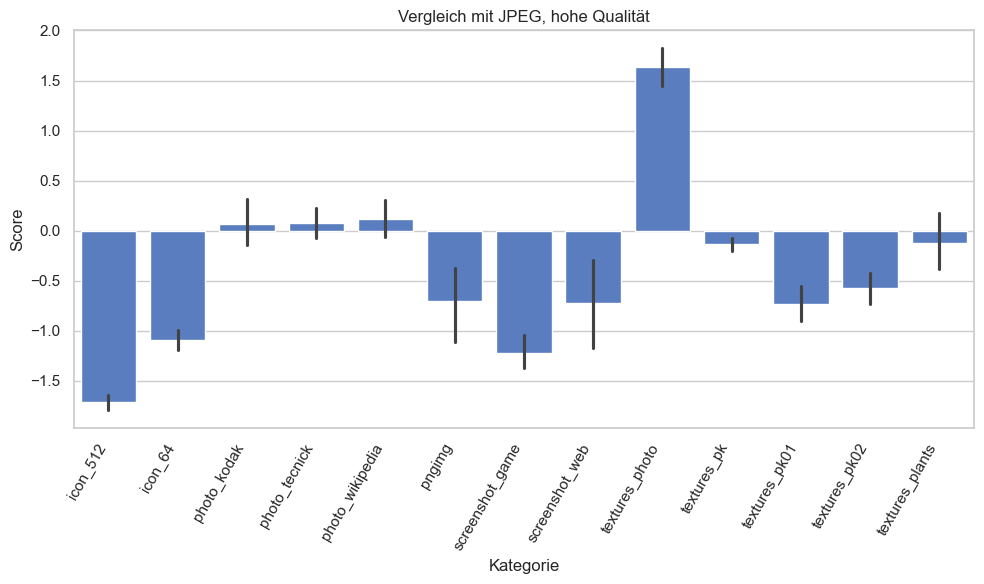

In [5]:
make_comparison(df_multicut, df_jpeg, 1, "Vergleich mit JPEG, hohe Qualität")

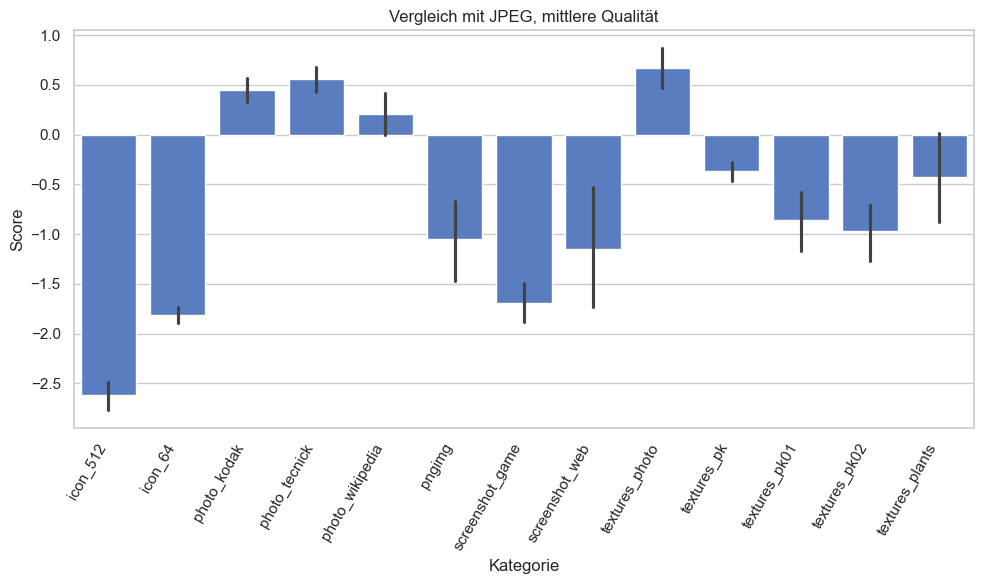

In [6]:
make_comparison(df_multicut, df_jpeg, 25,  "Vergleich mit JPEG, mittlere Qualität")

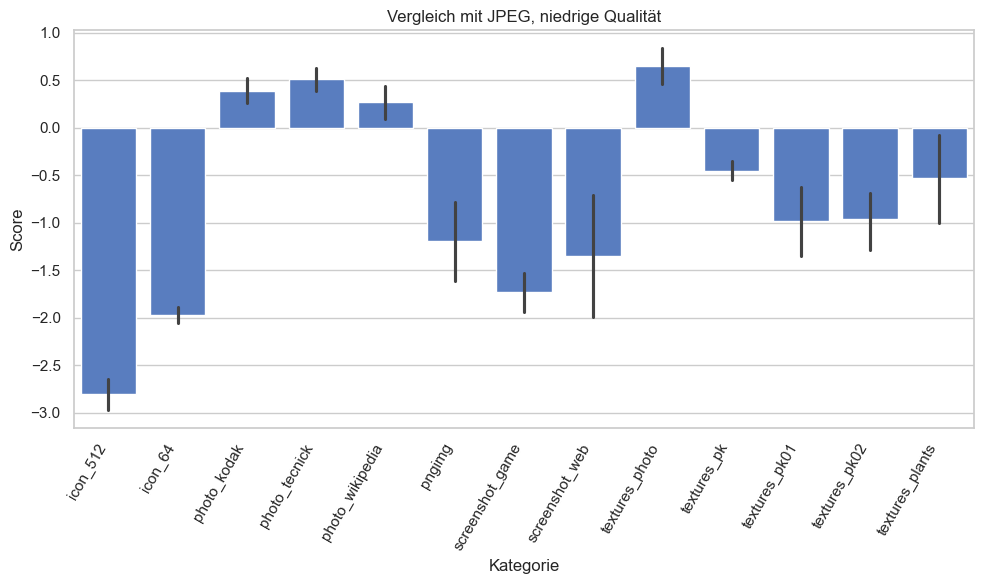

In [7]:
make_comparison(df_multicut, df_jpeg, 50,  "Vergleich mit JPEG, niedrige Qualität")

attempt to get argmin of an empty sequence
Computing the score failed for screenshot_web phoboslab.org.png


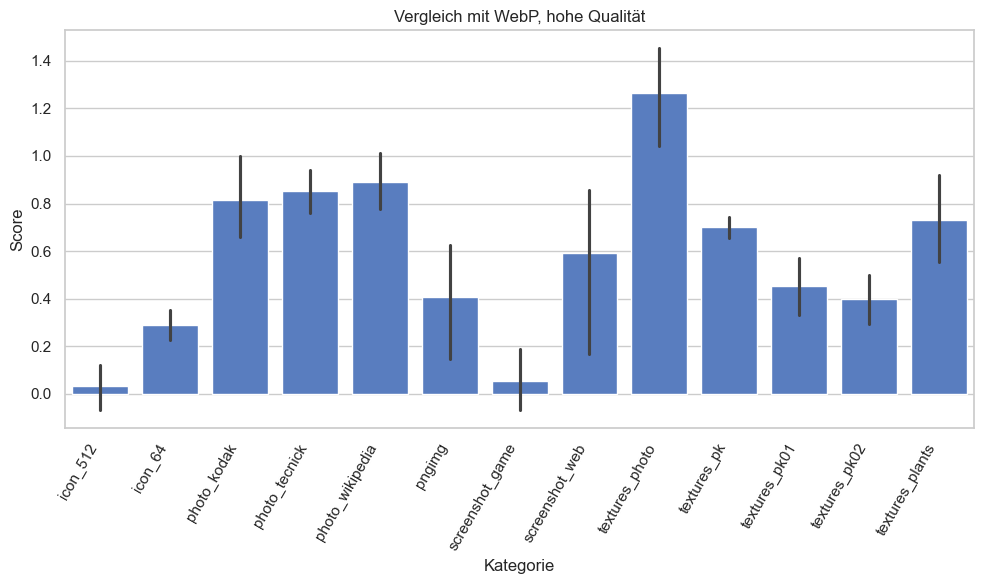

In [8]:
make_comparison(df_multicut, df_webp, 1, "Vergleich mit WebP, hohe Qualität")